In [70]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [71]:
f = open('models/waterer.ply')
lines = f.readlines()

In [72]:
from numpy.linalg import inv
def inv_homogenous_matrix(rvec, tvec):
    #https://mathematica.stackexchange.com/questions/106257/how-do-i-get-the-inverse-of-a-homogeneous-transformation-matrix
    rvec_out = inv(rvec)
    tvec_out = np.matmul(-1*rvec_out, tvec)
    return rvec_out, tvec_out

In [86]:
# read points from model.ply
points = []
point_num = int(lines[3].split()[-1])
print("point count: ", point_num)

sample_rate = 10

closest_point_to_zero = np.array([1000.0, 1000.0, 1000.0])

for idx, line in enumerate(lines[17:17+point_num]):

    if idx % sample_rate == 0:
        x, y, z = line.split(' ')[:3]
        x = float(x)/1000
        y = float(y)/1000
        z = float(z)/1000
        # you need to shift all model points cuz zero is not at the bottom of your model
        # gazebo uses model bottom as zero point
        points.append([x, y, z, 1.0])
        if(x**2+y**2+z**2 < np.sum(closest_point_to_zero**2)):
            closest_point_to_zero[0] = x
            closest_point_to_zero[1] = y
            closest_point_to_zero[2] = z

points = np.array(points)

# shift in z direction to move model refernce point to the bottom of model
model_zoffset = np.min(points[:, 2])
points[:, 2] -= model_zoffset
print(points)
print("z min: ", np.min(points[:, 2]))
print("z max: ", np.max(points[:, 2]))

point count:  22831
[[-0.006631  -0.0409674  0.0200471  1.       ]
 [-0.0205098 -0.0254599  0.0026443  1.       ]
 [ 0.0213234  0.0218684  0.0036827  1.       ]
 ...
 [ 0.0024658  0.0793528  0.1042928  1.       ]
 [ 0.0294175  0.046834   0.0353272  1.       ]
 [ 0.0114874  0.0682429  0.050721   1.       ]]
z min:  0.0
z max:  0.19318950000000001


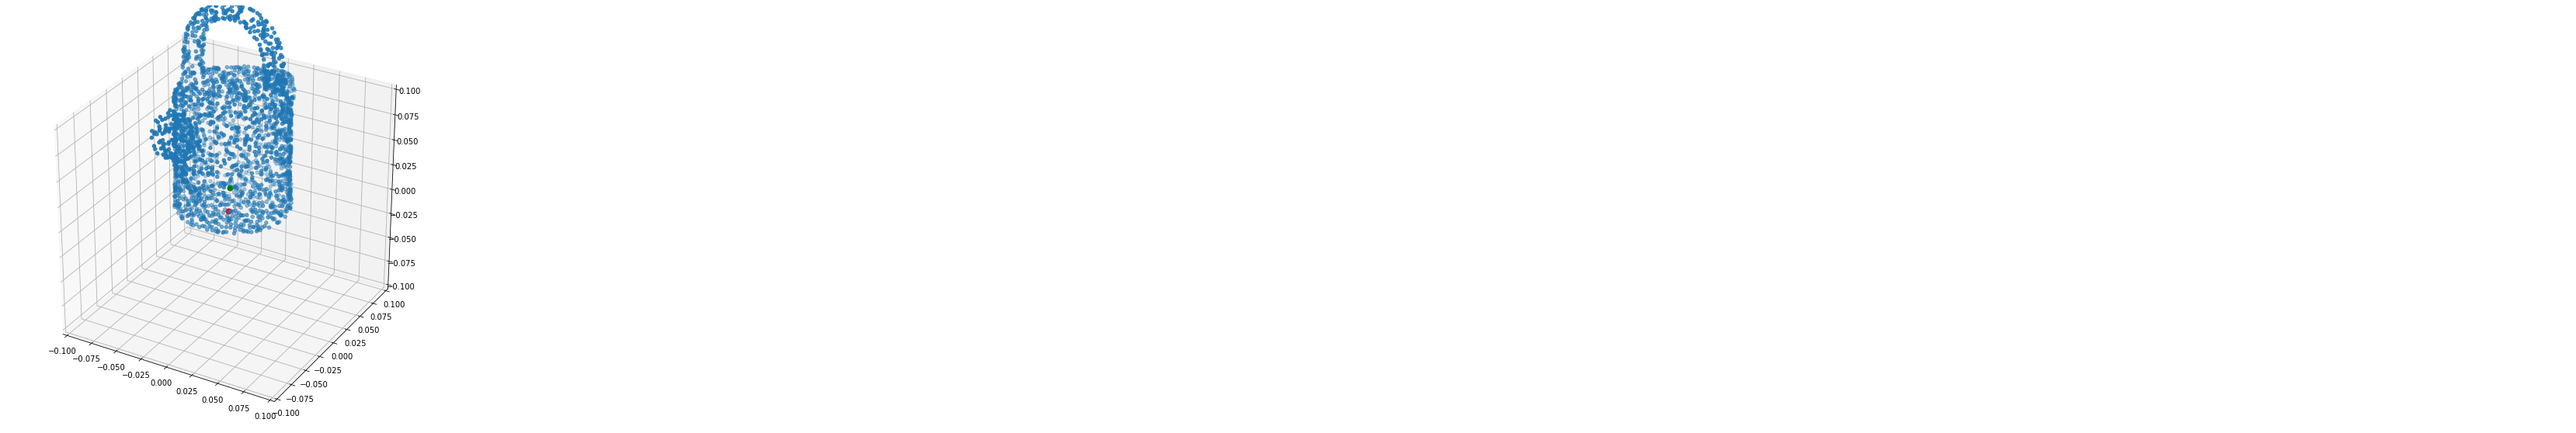

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10)) # specify figsize or your image will be distorted

ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(0, 0, 0, c = 'red', s = 50)
ax.scatter(0.000559, 0.001484, 0.022542000000000003, c = 'green', s = 50)
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
plt.show()
fig.savefig('result/waterer_dots_zero_point.png')

In [88]:
'''
test data information

camera rotation only (model pos = (0, 0, 0, 0, 0, 0))
   x,    y,    z,  roll, pitch,  yaw, img
   1,  0.5,  1.0,   0.0,   0.5, -2.5, 0002.png
 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, 0003.png
-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, 0004.png
 
'''

test_data = [[   1,  0.5,  1.0,   0.0,   0.5, -2.5, "rgb/0002.png"],
             [ 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, "rgb/0003.png"],
             [-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, "rgb/0004.png"]]

In [106]:
# calculate camera rvec, tvec

data_idx = 0

roll, pitch, yaw = test_data[data_idx][3:6]

Rx = [[1,            0,             0],
      [0, np.cos(roll), -np.sin(roll)],
      [0, np.sin(roll),  np.cos(roll)]]

Ry = [[ np.cos(pitch), 0, np.sin(pitch)],
      [0             , 1,             0],
      [-np.sin(pitch), 0, np.cos(pitch)]]

Rz = [[np.cos(yaw), -np.sin(yaw), 0],
      [np.sin(yaw),  np.cos(yaw), 0],
      [          0,            0, 1]]


camera_rvec = np.matmul( np.array(Rz), np.matmul(np.array(Ry), np.array(Rx)) ) #seem to be closer than Ry * Rz, gazebo rotation order x->y->z
camera_tvec = np.array(test_data[data_idx][0:3])

print(camera_rvec, camera_tvec)
camera_rvec, camera_tvec = inv_homogenous_matrix(camera_rvec, camera_tvec)
print(camera_rvec, camera_tvec)
extrinsic = np.append(camera_rvec, camera_tvec.reshape((3, 1)), axis=1)
#print(extrinsic)

[[-0.70306967  0.59847214 -0.38408871]
 [-0.52520872 -0.80114362 -0.28692283]
 [-0.47942554  0.          0.87758256]] [1.  0.5 1. ]
[[-0.70306967 -0.52520872 -0.47942554]
 [ 0.59847214 -0.80114362 -0.        ]
 [-0.38408871 -0.28692283  0.87758256]] [ 1.44509956 -0.19790034 -0.35003244]


In [107]:
points_cam_frame = np.matmul(extrinsic, points.transpose())

rot_to_cam = np.array([[ 0, -1, 0],
                       [ 0,  0, -1],
                       [ 1,  0, 0]])
points_cam_frame = np.matmul(rot_to_cam, points_cam_frame)

print(points_cam_frame.transpose())

[[0.16904803 0.31813808 1.46166696]
 [0.18977784 0.33252924 1.4716234 ]
 [0.2026586  0.36126518 1.41685667]
 ...
 [0.25999761 0.28222211 1.35168852]
 [0.21781554 0.34376658 1.38288263]
 [0.24569781 0.3295132  1.37686441]]


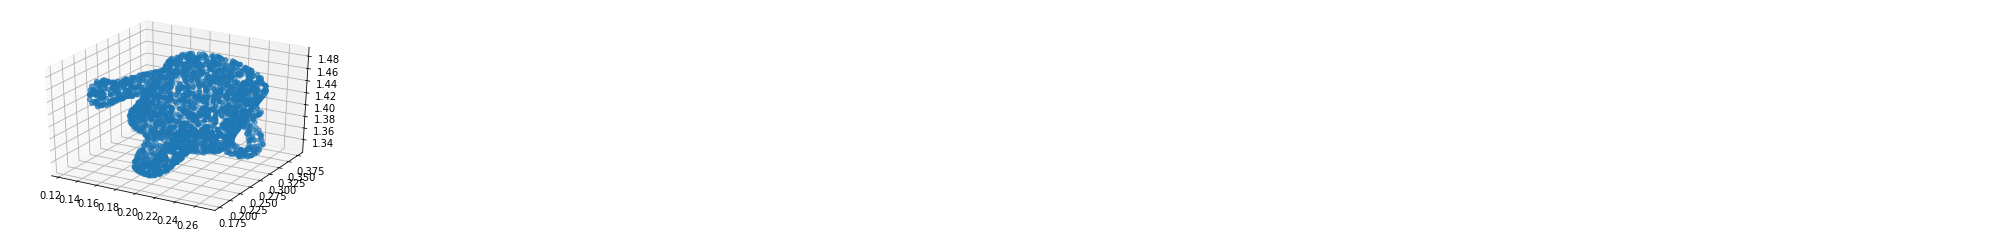

In [108]:
points_cam = points_cam_frame.transpose()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_cam[:, 0], points_cam[:, 1], points_cam[:, 2])
#ax.set_xlim3d(-101, 101)
#ax.set_ylim3d(-102, 102)
#ax.set_zlim3d(-103, 103)
plt.show()

In [109]:
intrinsic = [572.411400033838, 0.0, 320.0, 0.0, 572.4114000338382, 240, 0.0, 0.0, 1.0]
intrinsic = np.array(intrinsic).reshape((3, 3))
print(intrinsic)

[[572.41140003   0.         320.        ]
 [  0.         572.41140003 240.        ]
 [  0.           0.           1.        ]]


In [110]:
pixel_pos = np.matmul(intrinsic, points_cam_frame)
print(pixel_pos.transpose())

[[564.49844999 532.90593343   1.46166696]
 [579.55048892 543.53314163   1.4716234 ]
 [569.398231   546.83791172   1.41685667]
 ...
 [581.36592414 485.95239849   1.35168852]
 [567.20253942 528.6677372    1.38288263]
 [581.23684008 519.06457062   1.37686441]]


In [111]:
img = cv2.imread(test_data[data_idx][6])
print(img.shape)

(480, 640, 3)


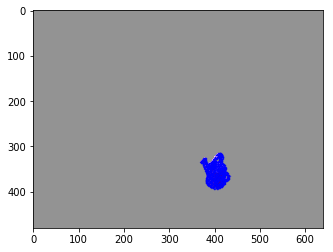

In [112]:
plt.imshow(img)
for row in pixel_pos.transpose():
    row[0] /= row[2]
    row[1] /= row[2]
    row[2] /= row[2]
    #print(row)
    if abs(row[0]) < 1000:
        #pass
        plt.scatter([row[0]], [row[1]], s = 0.1, c = 'blue')
plt.show()
#plt.savefig('result/mapping result.png')